### Logistic Regression (LogRegChoice.ipynb)
Train a differentially private logistic regression model while trying to optimize the choice of the regularization hyperparameter.

Goal: See how a ChoiceMaker performs on "easier" DP problems where a
probabilistic bound (from the ERM method) can be derived. Numbers that aren't significantly worse than
ERM are acceptable here.

Comparison: Differentially private ERM. We implement private logistic
regression, the ERM method, and a ChoiceMaker. We compare the misclassification rates of the algorithms.

Current Results: The Choicemaker performs better than ERM for low values of epsilon which is quite interesting.
It performs better than all three algorithms do as well.

In [1]:
#Add the fork of sklearn to the path.
import sys, os
#sys.path = ['./scikit-learn/build/lib.linux-x86_64-3.6/'] + sys.path
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from LRTools import DPLogisticRegression, DPAlg, DBTester
from LRTools import DB, DBSlicer
from ChoiceMaker import DTChoice
import ChoiceMaker
#import graphviz
import copy
%matplotlib inline
import pickle
import pdb
import DPrivacy as dp

In [2]:
#Retrain flags.
rerun_gen_training_data = False
rerun_exps = [True,False,True,True]

#### Methods for slicing datasets, allowing us to make a larger test set for our ChoiceMaker

In [6]:
def gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, reps, db, prng=None):
    """performs reshape_dset for each member of the Cartesian product of the arguments
    
    Params:
    db: Database to perform surgery on
    """
    for c in col_vals:
        for r in row_vals:
            for e in eps_vals:
                for ratio in ratios:
                    for x in range(0, reps):
                        G = DBSlicer.reshape_dset(db, ncol=c, nrow=r, y_ratio=ratio, prng=prng)
                        last_name = G.columns[-1]
                        yield DB(G.drop([last_name], axis=1), G[last_name], e, True).drop(0.04).normalize()

### Load Datasets

In [5]:
adult = pickle.load(open('log_regression_data/adult_preprocess.pkl', 'rb'))
magic = pickle.load(open('log_regression_data/magic_preprocess.pkl', 'rb'))
#default = pickle.load(open('log_regression_data/default_preprocess.pkl', 'rb'))
#This dataset doesn't work well for our study
lending = pickle.load(open('log_regression_data/lending_preprocess.pkl', 'rb'))

#Normalize dataset columns
def normalize_on_max(db):
    Xs = pd.get_dummies( db[db.columns[:-1]] )
    """
    Xs /= np.quantile(Xs, 0.95, axis=0)
    Xs = Xs.loc[:, ~np.any(Xs.apply(np.isnan), axis=0) ]
    """
    #Drop those columns with <4% nonzero elements
    Xs = Xs.loc[:, (Xs == 0).sum() / Xs.shape[0] < 0.96 ]
    for c in Xs.columns:
        if Xs[c].min() >= 0:
            Xs[c] = Xs[c] / Xs[c].max()
        elif Xs[c].max() <= 0:
            Xs[c] = -Xs[c] / Xs[c].min()
        else:
            rnge = Xs[c].max() - Xs[c].min()
            t = (Xs[c] - Xs[c].min()) / rnge
            Xs[c] = 2*t-1
    Xs['const'] = np.ones(Xs.shape[0])
    Xs['TARGET'] = db[db.columns[-1]]
    return Xs

#adult, magic, default, lending = [normalize_on_max(x) for x in [adult, magic, default, lending]]

adult_norm = DB.get_norm(adult)
#default_norm = DB.get_norm(default)
lending_norm = DB.get_norm(lending)
magic_norm = DB.get_norm(magic)

In [50]:
prng = np.random.RandomState(12345)
#eps_vals = [0.01, 0.025, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6]
col_vals = np.arange(2, 20, 2)
row_vals = [40, 100, 180, 300, 600, 1000, 2000, 4000]
ratios = [0.15, 0.3, 0.5, 0.7, 0.85]
num_reps = 2
C_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
alg_list = lambda: dict([(str(x), DP(C=x)) for x in C_list])

"""Simpler function call for gen_tset_size_range"""
def split_db(db, prng=None):
    return gen_tset_size_range([1.0], col_vals, row_vals, ratios, num_reps, db, prng)

In [112]:
directory = 'log_regression_data/'
if rerun_gen_training_data:
    adult_data = list(split_db(adult, prng))
    default_data = list(split_db(default, prng))
    lending_data = list(split_db(lending, prng))
    magic_data = list(split_db(magic, prng))
    pickle.dump(adult_data, open(directory + 'adult_slices.pkl', 'wb'))
    pickle.dump(default_data, open(directory + 'default_slices.pkl', 'wb'))
    pickle.dump(lending_data, open(directory + 'lending_slices.pkl', 'wb'))
    pickle.dump(magic_data, open(directory + 'magic_slices.pkl', 'wb'))
else:
    adult_data = pickle.load(open(directory + 'adult_slices.pkl', 'rb'))
    default_data = pickle.load(open(directory + 'default_slices.pkl', 'rb'))
    lending_data = pickle.load(open(directory + 'lending_slices.pkl', 'rb'))
    magic_data = pickle.load(open(directory + 'magic_slices.pkl', 'rb'))

In [5]:
DBTester.logistic_test(adult_data[-1].X, adult_data[-1].y, adult_norm * 2, 1, tol= 0.9)

NameError: name 'adult_data' is not defined

In [136]:
logistic_test(default_data[-1].X, default_data[-1].y, default_norm * 2, 10, tol=0.9)

Baseline: 0.022829
epsilons: 


./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


1.00 No; 

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


2.00 No; 

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


3.00 No; 

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:121: RuntimeWarning: overflow encountered in double_scalars
  + .5 * alpha * np.dot(w, w) + np.dot(b_vec, w)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


4.00 No; 5.00 No; 6.00 No; 7.00 No; 8.00 No; 9.00 No; 10.00 No; 

In [142]:
logistic_test(default[default.columns[:-1]], default[default.columns[-1]], default_norm * 2, 10, tol=0.9)

Baseline: 0.012978
epsilons: 


./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


1.00 No; 

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


2.00 No; 

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


3.00 No; 

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:121: RuntimeWarning: overflow encountered in double_scalars
  + .5 * alpha * np.dot(w, w) + np.dot(b_vec, w)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


4.00 No; 5.00 No; 6.00 No; 7.00 No; 8.00 No; 9.00 No; 10.00 No; 

In [132]:
logistic_test(lending_data[-1].X, lending_data[-1].y, lending_norm * 2, 1, tol=0.9)

Baseline: 0.046416
epsilons: 


./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


1.00 No; 2.00 No; 3.00 No; 4.00 No; 5.00 No; 6.00 No; 7.00 No; 8.00 Yes; 9.00 Yes; 10.00 Yes; 

In [133]:
logistic_test(magic_data[-1].X, magic_data[-1].y, magic_norm * 2, 1, tol=0.9)

Baseline: 0.184981
epsilons: 


./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:121: RuntimeWarning: overflow encountered in double_scalars
  + .5 * alpha * np.dot(w, w) + np.dot(b_vec, w)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


1.00 No; 2.00 No; 3.00 Yes; 4.00 No; 5.00 Yes; 6.00 Yes; 7.00 Yes; 8.00 Yes; 9.00 Yes; 10.00 Yes; 

In [ ]:
#TODO: Make a testing framework

In [16]:
ad = adult_data[-1]
adult_perfs = []
for e in np.exp(range (1, 25)):
    ad.epsilon = e
    adult_perfs.append([ DPAlg(C, adult_norm).error(ad)  for C in np.exp(range(0, 20)) ])

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-lear

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-lear

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-lear

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:121: RuntimeWarning: overflow encountered in double_scalars
  + .5 * alpha * np.dot(w, w) + np.dot(b_vec, w)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:121: RuntimeWarning: overflow encoun

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-lear

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linea

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/logistic.py:725: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarn

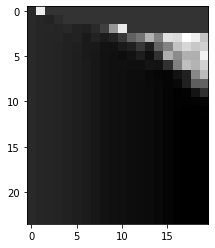

In [17]:
plt.imshow(np.array( adult_perfs ), cmap='Greys')

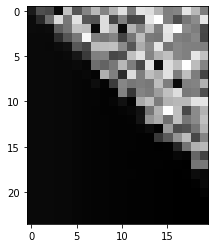

In [70]:
plt.imshow(np.array( adult_perfs ), cmap='Greys')

In [61]:
ld = lending_data[-1]
lending_perfs = []
for e in np.exp(range (1, 25)):
    ld.epsilon = e
    lending_perfs.append([ DPAlg(C, lending_norm).error(ld) for C in np.exp(range(0, 20))])

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3184530.20 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4991902.06 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2445869.71 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2450273.58 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: 

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             5511937.87 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4587711.08 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             8502568.41 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/l

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3726040.41 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             5635737.24 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4655743.70 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/l

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4590543.38 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7413745.49 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7395019.43 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/l

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1161690.49 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1669173.98 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1499993.43 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2855547.23 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: 

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3146859.15 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1365547.20 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1366447.87 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Ya

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1457132.81 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1459174.10 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2207297.23 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Ya

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             331012.47 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             331608.47 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             446920.91 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             456305.34 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: User

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1155158.22 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             501387.86 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             501674.58 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             758267.89 times or g

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             772187.43 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             665394.93 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1227080.31 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             15855718.01 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             14478432.52 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             158548.42 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             248532.17 times o

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             277680.03 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             229530.43 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             424958.96 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             184450.28 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: User

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             244785.12 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             451417.62 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             197201.48 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             60484.17 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             61754.21 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             100399.98 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             48455.15 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWar

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             67987.45 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             102807.38 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             84673.27 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             156672.89 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWa

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             90051.41 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             166067.26 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             72546.37 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1959442.77 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             21457.20 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             33635.17 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             16480.14 times or grea

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             37751.94 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             31123.59 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             57601.47 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             24995.50 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarn

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             64782.60 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             28899.47 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             29018.93 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Res

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9274.71 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             17392.84 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7864.47 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7827.41 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9204.78 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9211.36 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             13931.72 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             11494.23 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarnin

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             18376.84 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             18330.42 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             43242.49 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             61654.87 times or greate

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3120.90 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4591.85 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3999.63 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7485.39 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning:

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4245.49 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7844.29 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3409.74 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3412.75 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning:

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             14169.49 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             99924.53 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             79801.37 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.lin

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1228.59 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1849.05 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1539.01 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2852.29 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning:

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1266.02 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1914.06 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1649.35 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3041.63 times or greater. E

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             393.00 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             616.05 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             301.84 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             302.39 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             688.30 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             568.95 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1053.37 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             457.21 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: Fo

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1118.95 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             488.81 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             489.50 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             740.47 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: Fo

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             120.11 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             120.00 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             163.83 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             159.23 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             168.42 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             168.52 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             254.83 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             209.88 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             208.41 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             336.58 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             335.73 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             68.10 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             129.64 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             57.30 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             57.16 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             143.27 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             62.19 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             62.23 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             94.13 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1956.75 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1786.78 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             19.57 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             30.67 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             28.33 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             52.44 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             22.76 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             22.78 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at 

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             26.35 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             26.46 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             39.99 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             44.57 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at 

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7.74 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             11.38 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9.91 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             18.55 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at le

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             19.44 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             8.45 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             8.46 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             12.79 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at le

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3.00 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.92 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             5.10 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.38 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at leas

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3.84 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7.11 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3.09 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3.09 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at leas

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             20.68 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             11.91 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             13.10 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             12.92 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at 

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.62 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.13 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.14 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.72 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at leas

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.26 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             5.34 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7.61 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4.38 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at leas

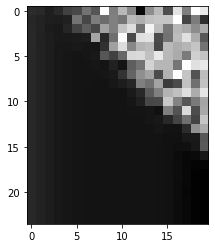

In [67]:
plt.imshow( lending_perfs, cmap='Greys')

In [71]:
dd = default_data[-1]
default_perfs = []
for e in np.exp(range (1, 25)):
    dd.epsilon = e
    default_perfs.append([ DPAlg(C, default_norm).error(dd) for C in np.exp(range(0, 20))])

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: Run

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: Runtime

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: Run

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: Runtime

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: Runtime

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: Runtime

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: Runtime

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: Run

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: Run

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: Runtime

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: Run

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: Run

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: Run

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: Runtime

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: Runtime

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weig

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             inf times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: RuntimeWarning: divide by zero encountered in double_scalars
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_re

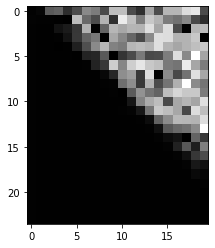

In [72]:
plt.imshow( default_perfs, cmap='Greys')

In [82]:
md = magic_data[-1]
magic_perfs = []
for e in np.exp(range(1, 25)):
    md.epsilon = e
    magic_perfs.append([ DPAlg(C, magic_norm).error(md) for C in np.exp(range(0, 20))])

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             18.41 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             19.16 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             18.67 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             18.11 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at 

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             308.44 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1201.93 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1398.31 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Researc

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1429907.83 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             186582.24 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             195354.85 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             69290057.80 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             25728328.25 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             32073805.30 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/buil

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             550.69 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             13.31 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             95.66 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             54.77 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             25566.84 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             361500.82 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             31138.12 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.li

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             8228148.81 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3332377.62 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             10307159.70 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.84 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             94.65 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.77 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             6.10 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at lea

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1305.34 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9413.53 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2815.62 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             829687.04 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             174509.47 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             207113.27 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             24195731.84 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             65499935.93 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             25609076.97 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             5750.54 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             716.98 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             55.98 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             151.60 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarni

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9289.38 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9726.15 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             39885.92 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1211462.81 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3449748.85 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1280938.04 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/l

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             202.37 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             5.65 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             22.01 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             25.61 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at 

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3578.05 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             14673.21 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9304.63 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1269091.68 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             471230.77 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             587452.24 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             26.13 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             455.16 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             214.89 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             24.99 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For a

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             9029.48 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             41307.69 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             8688.32 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3261049.79 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1275000.87 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1590906.86 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/l

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             681.53 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             470.83 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3544.39 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             462.49 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: Fo

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             60315.18 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             171752.88 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             63774.15 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.li

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             8.27 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             8.80 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             63.43 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             18.97 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at le

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3146.57 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             11358.03 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3173.45 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             215305.83 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.17 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.76 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3.71 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             432.57 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             513.38 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2569.81 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1157.56 times or greater. Exp

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.36 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             14.25 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.78 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             8.34 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at lea

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             533.21 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2760.24 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1117.89 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3457.67 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWa

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             36.42 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.55 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.36 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4.18 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at lea

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1168.06 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1456.15 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             10112.52 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             40.12 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             22.38 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             102.39 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             21.54 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3943.46 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             4.93 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             6.04 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.69 times or greater. Expect ans

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             426.73 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             541.93 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3807.98 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1098.48 times or greater. Exp

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             503.47 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             142.27 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             575.24 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             156.99 times or greater. Expec

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             73.34 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             515.35 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             148.66 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             402.45 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For 

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             1.33 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7.04 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.74 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7.80 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at leas

/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.72 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             7.37 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             2.88 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at least 5% of the coeffients, the noise is             3.60 times or greater. Expect answer to be noisy
  % float(mean / small_weight))
/home/jacob/Desktop/Yang_Research/Python/LRTools/log_regression.py:148: UserWarning: For at leas

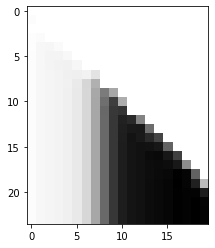

In [84]:
plt.imshow( np.maximum( magic_perfs, 0), cmap='Greys')

### Experiment

##### Setup
We have four dataset lists, each containing slices of a dataset. We train train four
choicemakers in method inspired by cross-validation:
Choicemaker i uses all partitions except for i as training data and is then tested on list i.
Testing involves computing the error for each of the base algorithms, the choicemaker, ERM,
and non-private cross-validation, averaged over each dataset in list i.

In [19]:
"""choicemaker wrapper method
"""
def get_cm(db):
    return DTChoice(db, DBMetafeatures(), alg_list())

In [42]:
local_dir = 'log_regression_metadata/'
def do_exp(data, index, msl=10, md=2, suffix=None):
    if suffix is None:
        loc = local_dir + 'cm_' + str(index) + '.pkl'
    else:
        loc = local_dir + suffix + '.pkl'
    if rerun_exps[index]:
        cm = get_cm(data)
        pickle.dump(cm, open(loc, 'wb'))
    else:
        cm = pickle.load(open(loc, 'rb'))
    cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=msl, max_depth=md)
    cm.retrain_model()
    cm.algs = alg_list()
    return cm

In [108]:
adult_cm = do_exp(adult_data, 0)

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linu

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/pyt

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-

./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
./scikit-learn/build/lib.linux-x86_64-3.6/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-pac

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-pa

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-p

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-pac

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/jacob/anaconda3/lib/python3.6/site-

KeyboardInterrupt: 

In [47]:
adult_data[-1]

In [37]:
adult_cm.regrets.groupby( adult_cm.X.eps ).mean()

,1e-09,0.0004,0.004,0.02,0.1,0.5,1.0
eps,,,,,,,
0.010,0.520053,0.525930,0.518282,0.524063,0.522953,0.522381,0.523536
0.025,0.528015,0.526365,0.525230,0.522775,0.524876,0.524712,0.525030
0.050,0.528028,0.524552,0.527022,0.525968,0.522518,0.523657,0.524970
0.100,0.525453,0.529416,0.528944,0.530880,0.527380,0.523537,0.522389
0.200,0.533547,0.533123,0.532084,0.524872,0.528344,0.526524,0.524885
0.400,0.540806,0.538584,0.538300,0.537511,0.532650,0.527199,0.527376
0.800,0.539016,0.541552,0.545505,0.546945,0.539836,0.527809,0.532370
1.600,0.544741,0.545059,0.545940,0.547133,0.544311,0.537371,0.533876


In [25]:
adult_cm.regrets.mean(axis=0)

1e-09     0.532458
0.0004    0.533073
0.004     0.532663
0.02      0.532518
0.1       0.530358
0.5       0.526649
1.0       0.526804
dtype: float64

In [72]:
M1 = adult_cm.regrets.groupby([adult_cm.X[c] for c in adult_cm.X]).mean()

In [43]:
default_cm = do_exp(default_data, 1, suffix='adult_cm')

In [73]:
M2 = default_cm.regrets.groupby([default_cm.X[c] for c in default_cm.X]).mean()

In [42]:
lending_cm = do_exp(lending_data, 2)

In [75]:
M3 = lending_cm.regrets.groupby([lending_cm.X[c] for c in lending_cm.X]).mean()

In [64]:
magic_cm = do_exp(magic_data, 3)

In [65]:
magic_cm.regrets.groupby(magic_cm.X.nrow).mean()

,0.0004,0.004,0.02,0.1,0.5,1.0,1e-09
nrow,,,,,,,
20,0.467639,0.469491,0.468657,0.475833,0.474815,0.489769,0.465139
40,0.437315,0.437847,0.447315,0.463611,0.492106,0.490995,0.438866
100,0.395870,0.402343,0.418454,0.447991,0.483398,0.489935,0.397361
150,0.383852,0.387698,0.409000,0.450296,0.488506,0.486154,0.382568
300,0.353164,0.367960,0.395253,0.447231,0.483343,0.491154,0.353670
600,0.331057,0.350415,0.385924,0.436588,0.476912,0.493653,0.331975
1000,0.316739,0.339331,0.375760,0.432024,0.480404,0.485400,0.312358
2000,0.297624,0.325435,0.373738,0.429812,0.477460,0.486007,0.292694
3000,0.291488,0.323964,0.370455,0.430332,0.479501,0.493579,0.285493


In [77]:
(M1 - M2).mean()# Scores are looking too similar.

0.0004    0.013010
0.004     0.012488
0.02      0.014503
0.1       0.010442
0.5       0.002432
1.0       0.003528
1e-09     0.009577
dtype: float64

In [124]:
"""
{dbname}_test_cm contains all databases which are not named {dbname} as training data.
"""

default_test_cm = DTChoice(adult_data + lending_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       pd.concat((adult_cm.regrets, lending_cm.regrets, magic_cm.regrets), ignore_index=True))
default_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
default_test_cm.retrain_model()

adult_test_cm = DTChoice(default_data + lending_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       pd.concat((default_cm.regrets, lending_cm.regrets, magic_cm.regrets), ignore_index=True))
adult_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
adult_test_cm.retrain_model()

lending_test_cm = DTChoice(adult_data + default_data + magic_data, DBMetafeatures(), 
                       alg_list(),
                       pd.concat((adult_cm.regrets, default_cm.regrets, magic_cm.regrets), ignore_index=True))
lending_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
lending_test_cm.retrain_model()

magic_test_cm = DTChoice(adult_data + default_data + lending_data, DBMetafeatures(), 
                       alg_list(),
                       pd.concat((adult_cm.regrets, default_cm.regrets, lending_cm.regrets), ignore_index=True))
magic_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
magic_test_cm.retrain_model()

In [125]:
#We test every {skip} database for better efficiency.
def get_test_set(skip):
    adult_data_test = []
    for i in range(len(adult_data)):
        if i%skip == 0:
            adult_data_test.append(copy.copy(adult_data[i]))
    default_data_test = []
    for i in range(len(default_data)):
        if i%skip == 0:
            default_data_test.append(copy.copy(default_data[i]))
    lending_data_test = []
    for i in range(len(lending_data)):
        if i%skip == 0:
            lending_data_test.append(copy.copy(lending_data[i]))
    magic_data_test = []
    for i in range(len(magic_data)):
        if i%skip == 0:
            magic_data_test.append(copy.copy(magic_data[i]))
    return (adult_data_test, default_data_test, lending_data_test, magic_data_test)

(adult_data_test, default_data_test, lending_data_test, magic_data_test) = get_test_set(3) #Used skip of 3, still testing 2430
epsilons = [db.epsilon for db in lending_data_test]

In [126]:
adult_errors = [adult_test_cm.get_errors(x, ratio=0.2) for x in adult_data_test]
adult_errors = pd.concat(adult_errors, ignore_index=True)

In [26]:
lending_errors = [lending_test_cm.get_errors(x, ratio=0.2) for x in lending_data_test]
lending_errors = pd.concat(lending_errors, ignore_index=True)

In [27]:
default_errors = [default_test_cm.get_errors(x, ratio=0.2) for x in default_data_test]
default_errors = pd.concat(default_errors, ignore_index=True)

In [28]:
magic_errors = [magic_test_cm.get_errors(x, ratio=0.2) for x in magic_data_test]
magic_errors = pd.concat(magic_errors, ignore_index=True)

### Kamalika's method

In [29]:
def get_dp_logistic_regression(X_train, y_train, X_test, y_test, 
                             epsilon, ratio, param_list):
    train_eps = epsilon*ratio
    validation_eps = epsilon-train_eps
    #Begin validation
    utils = []
    for C in param_list:
        model = DPLogisticRegression(train_eps, C=C, K=1.02, fit_intercept=True)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = (preds == y_test).sum() / y_test.size
        beta = max(1.0/y_test.size, 1.0/y_train.size)
        score += np.random.exponential(1/validation_eps)*beta*2
        utils.append(score)
    return np.array(utils).argmax()

In [30]:
def test_db_MRE(data_test, ratio=0.8, splits=5, do_private=True):
    kf = model_selection.KFold(splits)
    avgs = []
    for db in data_test:
        avg = 0
        for train_idx, test_idx in kf.split(db.X):
            X_val = db.X.iloc[test_idx]
            y_val = db.y.iloc[test_idx]
            X_train = db.X.iloc[train_idx]
            y_train = db.y.iloc[train_idx]
            X_ttrain, X_ttest, y_ttrain, y_ttest = model_selection.train_test_split(X_train, y_train, test_size=0.2)
            if pd.Series.nunique(y_ttrain) == 1:
                avg += 1.0
                continue
            if do_private:
                eps = db.epsilon
            else:
                eps=100
            idx = get_dp_logistic_regression(X_ttrain, y_ttrain, X_ttest, y_ttest, eps, ratio, C_list)
            alg = DP(C_list[idx])
            if do_private:
                alg.model.set_epsilon(eps - (1-ratio)*eps)
            else:
                alg.model.set_epsilon(100)
            alg.model.fit(X_ttrain, y_ttrain)
            y_hat = alg.model.predict(X_val)
            avg += (y_hat == y_val).sum() / y_val.size
        avg /= splits
        avgs.append(1.0-avg)
    return np.array(avgs)

In [31]:
"""Performance of ERM on each dataset slice. We generate the test sets freshly because
the choicemaker alters epsilon yet we need the same amount of budget.
"""
(adult_data_test, default_data_test, lending_data_test, magic_data_test) = get_test_set()
adult_perf = test_db_MRE(adult_data_test)
lending_perf = test_db_MRE(lending_data_test)
default_perf = test_db_MRE(default_data_test)
magic_perf = test_db_MRE(magic_data_test)

In [32]:
"""Performance of non-private cross-validation on each dataset partition. """
(adult_data_test, default_data_test, lending_data_test, magic_data_test) = get_test_set()
adult_perf_non = test_db_MRE(adult_data_test, do_private=False)
lending_perf_non = test_db_MRE(lending_data_test, do_private=False)
default_perf_non = test_db_MRE(default_data_test, do_private=False)
magic_perf_non = test_db_MRE(magic_data_test, do_private=False)

In [33]:
adult_errors['Stability'] = adult_perf
adult_errors['NonPrivate'] = adult_perf_non
adult_errors['eps'] = epsilons
lending_errors['Stability'] = lending_perf
lending_errors['NonPrivate'] = lending_perf_non
lending_errors['eps'] = epsilons
default_errors['Stability'] = default_perf
default_errors['NonPrivate'] = default_perf_non
default_errors['eps'] = epsilons
magic_errors['Stability'] = magic_perf
magic_errors['NonPrivate'] = magic_perf_non
magic_errors['eps'] = epsilons

In [41]:
""" Code for dumping all of the errors to a files
pickle.dump(adult_errors, open('log_regression_metadata/adult_results.pkl', 'wb'))
pickle.dump(lending_errors, open('log_regression_metadata/lending_results.pkl', 'wb'))
pickle.dump(default_errors, open('log_regression_metadata/default_results.pkl', 'wb'))
pickle.dump(magic_errors, open('log_regression_metadata/magic_results.pkl', 'wb'))
"""

In [56]:
adult_errors2['Stability'] = adult_perf
adult_errors2['NonPrivate'] = adult_perf_non
adult_errors2['eps'] = epsilons

In [80]:
tst = adult_errors2.groupby('eps').mean()

In [60]:
tst = pd.concat([adult_errors, lending_errors, default_errors, magic_errors], ignore_index=True).groupby('eps').mean()

In [35]:
import matplotlib.patches as mpatches

Text(0.5,1,'Errors of Stability, C_reg, and NonPrivate over 4 datasets')

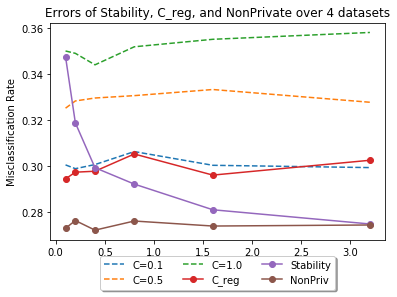

In [81]:
fig, axis=plt.subplots()
for a in alg_list:
    axis.plot(tst.index, tst[a.name], '--', label='C=%s' % a.name)
axis.plot(tst.index, tst['cm'], 'o-', label='C_reg')
axis.plot(tst.index, tst['Stability'], 'o-', label='Stability')
axis.plot(tst.index, tst['NonPrivate'], 'o-', label='NonPriv')
axis.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=3)
axis.set_ylabel('Misclassification Rate')
axis.set_title('Errors of Stability, C_reg, and NonPrivate over 4 datasets')

In [68]:
adult_cm.regrets.mean(axis=0)

0.1    0.300858
0.5    0.328354
1.0    0.349988
dtype: float64

In [77]:
adult_data_test

 ...]

In [79]:
adult_data_test[0]